<a href="https://colab.research.google.com/github/amank56/Stock-prediction/blob/master/LSTM_Keras_stock_prediction_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving sector_Combine_tech_reuter.csv to sector_Combine_tech_reuter.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['sector_Combine_tech_reuter.csv']))



In [5]:
df.head()

,Unnamed: 0,Firm,Date,Headlines,Label,Description,Open,Close
0,2,Apple,03-19-2012,UPDATE 6-Apple's Cook finally shares $98 billi...,1,"Apple Inc CEO\nTim Cook, moving swiftly after ...",85.48143,85.871429
1,3,Apple,03-19-2012,RPT-US STOCKS-S&P within 10 pct of record high...,1,The S&P 500 extended its\nrally on Monday to c...,85.48143,85.871429
2,4,Apple,03-19-2012,S&P within 10 pct of record high; Apple up on ...,1,The S&P 500 extended its\nrally on Monday to c...,85.48143,85.871429
3,5,Apple,03-19-2012,BreakingViews: So what's Apple really going to...,1,(The author is a Reuters Breakingviews columni...,85.48143,85.871429
4,6,Apple,03-19-2012,"Instant View: Apple to pay dividend, buy back ...",1,Apple Inc said it plans to pay a quarterly div...,85.48143,85.871429


In [0]:
#processing the text of headline/Description

col_name='Headlines'
# Remove all the special characters
df[col_name]=df[col_name].map(lambda x: re.sub(r'\W+', ' ', x))

# remove all single characters
df[col_name]=df[col_name].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',x))

# Remove single characters from the start
df[col_name]=df[col_name].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',x))

#Substituting multiple spaces with single space
df[col_name]=df[col_name].map(lambda x: re.sub(r'\s+', ' ',x,flags=re.I))

# Removing prefixed 'b'
df[col_name]=df[col_name].map(lambda x: re.sub(r'^b\s+', ' ',x))

Understand the distribution better.


Text(0.5, 1.0, 'Number of +ive and -ive messages - 0 is -ve and +ive is 1')

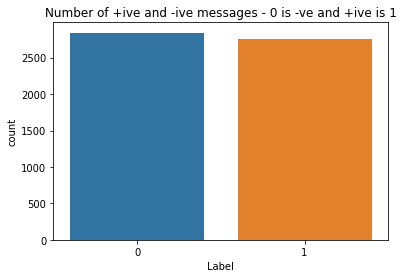

In [7]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of +ive and -ive messages - 0 is -ve and +ive is 1')

1. Create input and output vectors.

2. Process the labels.

In [0]:
X = df.Headlines
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

**Process the data**

Tokenize the data and convert the text to sequences.

Add padding to ensure that all the sequences have the same shape.

There are many ways of taking the max_len and here an arbitrary length of 150 is chosen

In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

**RNN**

Define the RNN structure.

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [12]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Fit on the training data.

In [14]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

Train on 3808 samples, validate on 952 samples
Epoch 1/10
3808/3808 [==============================] - 7s 2ms/step - loss: 0.5682 - accuracy: 0.7054 - val_loss: 0.7214 - val_accuracy: 0.5767
Epoch 2/10
3808/3808 [==============================] - 7s 2ms/step - loss: 0.5448 - accuracy: 0.7253 - val_loss: 0.7308 - val_accuracy: 0.6019
Epoch 3/10
3808/3808 [==============================] - 7s 2ms/step - loss: 0.5250 - accuracy: 0.7426 - val_loss: 0.7389 - val_accuracy: 0.5966
Epoch 4/10
3808/3808 [==============================] - 7s 2ms/step - loss: 0.5067 - accuracy: 0.7555 - val_loss: 0.7563 - val_accuracy: 0.5945
Epoch 5/10
3808/3808 [==============================] - 7s 2ms/step - loss: 0.4829 - accuracy: 0.7760 - val_loss: 0.8281 - val_accuracy: 0.6040
Epoch 6/10
3808/3808 [==============================] - 7s 2ms/step - loss: 0.4617 - accuracy: 0.7915 - val_loss: 0.8264 - val_accuracy: 0.6103
Epoch 7/10
3808/3808 [==============================] - 7s 2ms/step - loss: 0.4427 - accu

Process the test set data.

In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [17]:
accr = model.evaluate(test_sequences_matrix,Y_test)

841/841 [==============================] - 1s 615us/step


In [18]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 1.026
  Accuracy: 0.587
